# App Reviews AI - Enhanced Analysis Dashboard

This notebook demonstrates how to use the App Reviews AI system to analyze app reviews from the Google Play Store and generate a comprehensive, insightful dashboard that's ready to share with stakeholders.

## What's Included in the Enhanced Dashboard

This notebook creates a fully comprehensive analysis dashboard that includes:

1. **Interactive Visualizations**
   - Rating distributions with trend analysis
   - Sentiment analysis with distribution charts
   - Topic modeling with detailed topic breakdowns
   - Version-based analysis showing performance across app versions
   - Keyword analysis and importance rankings

2. **Explanatory Elements**
   - Detailed explanations for each visualization
   - Interpretation guidance for all metrics
   - Context for why each chart matters and how to use the insights

3. **Tabular Insights**
   - Comprehensive metrics tables by version
   - Topic details with representative keywords
   - Keyword importance heatmaps
   - Performance comparison across versions

4. **AI-Generated Insights**
   - Critical issues identification
   - User pain points categorization
   - Quick win opportunities
   - Strengths to build upon
   - Version-specific findings

This enhanced dashboard provides a complete picture of app performance based on user reviews, with actionable insights that product managers, developers, and executives can use to drive improvements.

## Options for Review Data

This notebook provides multiple options for working with review data:

1. **Fetch new reviews** from the Google Play Store API
2. **Load existing reviews** from CSV storage
3. **Retrieve reviews** from the vector database
4. **Generate mock data** as a fallback

This flexible approach allows you to run the analysis without repeatedly making API calls, which conserves API quotas and speeds up the workflow when iterating on the analysis.

# Setup

First, let's set up the environment and import the necessary modules.

In [1]:
# Import required libraries
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from dotenv import load_dotenv

# Add the project root to the path so we can import our modules
# Get the absolute path to the project root
project_root = os.path.abspath(os.path.join(os.path.dirname('__file__'), '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)
    print(f"Added {project_root} to Python path")

# Load environment variables from .env file
load_dotenv()

# Check if OpenAI API key is available
if not os.environ.get("OPENAI_API_KEY"):
    print("⚠️ WARNING: OPENAI_API_KEY not found in environment variables. Some features may not work.")

Added /Users/dipesh/Local-Projects/indigo-reviews-ai to Python path


## Initialize the Runner

Now let's import and initialize our review analysis runner.

In [ ]:
# Ensure all required directories exist
import os
os.makedirs(os.path.join('..', 'logs'), exist_ok=True)
os.makedirs(os.path.join('..', 'data'), exist_ok=True)
os.makedirs(os.path.join('..', 'reports'), exist_ok=True)

from src.runner import ReviewAnalysisRunner

# Initialize the runner
runner = ReviewAnalysisRunner()

# Initialize the modules
runner._initialize_modules()

DEBUG: Applying APP_ID from environment: 'in.goindigo.android  # Google Play Store app ID'
2025-05-08 08:40:54,903 - app_reviews - INFO - Initializing modules...
2025-05-08 08:40:54,905 - app_reviews - INFO - Initializing acquisition module...
Acquisition module using APP_ID from environment: in.goindigo.android  # Google Play Store app ID
2025-05-08 08:40:54,908 - app_reviews - INFO - Using app ID: in.goindigo.android  # Google Play Store app ID
2025-05-08 08:40:54,909 - app_reviews - INFO - Using MAX_REVIEWS from environment: 11
2025-05-08 08:40:54,926 - app_reviews - ERROR - Failed to fetch app information: URL can't contain control characters. '/store/apps/details?id=in.goindigo.android  ' (found at least ' ')
2025-05-08 08:40:54,927 - app_reviews - WARNING - Using generic app information fallback
2025-05-08 08:40:54,927 - app_reviews - INFO - Initializing storage module...
Initialize: Using default file path: /Users/dipesh/Local-Projects/indigo-reviews-ai/src/data/reviews.csv
2025

2025-05-08 08:40:56,876 - urllib3.connectionpool - WARNING - Retrying (Retry(total=1, connect=1, read=2, redirect=None, status=None)) after connection broken by 'NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x147537690>: Failed to resolve 'us.i.posthog.com' ([Errno 8] nodename nor servname provided, or not known)")': /batch/
2025-05-08 08:40:56,878 - urllib3.connectionpool - WARNING - Retrying (Retry(total=0, connect=0, read=2, redirect=None, status=None)) after connection broken by 'NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x106506e50>: Failed to resolve 'us.i.posthog.com' ([Errno 8] nodename nor servname provided, or not known)")': /batch/
2025-05-08 08:40:56,882 - backoff - INFO - Backing off send_request(...) for 1.4s (requests.exceptions.ConnectionError: HTTPSConnectionPool(host='us.i.posthog.com', port=443): Max retries exceeded with url: /batch/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x1475b3e

## Fetch or Load App Reviews

You can either fetch new reviews from the Google Play Store or load existing reviews from storage.
Choose one of the options below based on your needs.

In [3]:
# Option 1: Fetch new reviews from Google Play Store
# Uncomment this section to fetch fresh reviews

# app_id = "com.example.app"  # Example mobile app ID
# start_date = "6 months ago"  # Fetch reviews from 6 months ago
# end_date = "now"             # Up to today
# max_reviews = 1000           # Limit to 1000 reviews for demonstration purposes

# reviews_df = runner.fetch_reviews(
#     app_id=app_id,
#     start_date=start_date,
#     end_date=end_date,
#     max_reviews=max_reviews
# )

# Make sure data directory exists
project_root = os.path.abspath(os.path.join(os.path.dirname('__file__'), '..'))
data_dir = os.path.join(project_root, 'data')
os.makedirs(data_dir, exist_ok=True)

# Temporarily disable mock mode for data loading
original_mock_value = os.environ.get("USE_MOCK_DATA", "")
os.environ["USE_MOCK_DATA"] = "false"

# Option 2: Load reviews from a previously saved CSV file
# This is useful to avoid making API calls repeatedly
use_storage = True  # Set to False to skip this option

reviews_df = None
if use_storage:
    try:
        # Direct load from the CSV file to bypass storage module issues
        csv_path = os.path.join(project_root, 'data', 'reviews.csv')
        if os.path.exists(csv_path):
            print(f"Loading reviews from: {csv_path}")
            reviews_df = pd.read_csv(csv_path)
            
            # Convert date column to datetime if it exists
            if 'date' in reviews_df.columns:
                reviews_df['date'] = pd.to_datetime(reviews_df['date'], errors='coerce')
                
            if reviews_df.empty:
                raise ValueError("CSV file exists but contains no data")
                
            print(f"Successfully loaded {len(reviews_df)} reviews from CSV file")
        else:
            # Fall back to storage module
            print("CSV file not found, trying storage module...")
            reviews_df = runner.storage.retrieve_data()
            
            if reviews_df.empty:
                raise ValueError("No reviews found in storage")
            
            print(f"Successfully loaded {len(reviews_df)} reviews from storage")
    except Exception as e:
        print(f"Error loading from storage: {e}")
        reviews_df = None

# Option 3: Load reviews from Vector Database
# Try vector DB if storage failed
use_vector_db = (reviews_df is None)

if use_vector_db:
    try:
        print("Loading reviews from vector database...")
        
        # Force using the non-mock collection
        if hasattr(runner.vector_db, '_collection_name'):
            # Store the original collection name
            original_collection = runner.vector_db._collection_name
            
            # Use the non-mock collection name
            if original_collection.endswith('_mock'):
                real_collection = original_collection.replace('_mock', '')
            else:
                real_collection = original_collection
                
            print(f"Switching from {original_collection} to {real_collection}")
            runner.vector_db._collection_name = real_collection
            
            # Re-initialize collection with new name
            runner.vector_db._collection = runner.vector_db._client.get_collection(
                name=real_collection,
                embedding_function=runner.vector_db._embedding_function
            )
        
        # Get vector DB stats
        stats = runner.vector_db.get_collection_stats()
        print(f"Vector DB collection: {stats['collection_name']}")
        print(f"Document count: {stats['document_count']}")
        
        if stats['document_count'] == 0:
            raise ValueError("No documents found in vector database")
            
        # Create a query that matches everything (we'll limit results)
        all_docs = []
        batch_size = 100
        total_batches = (stats['document_count'] + batch_size - 1) // batch_size
        
        for i in range(total_batches):
            # Use a different query for each batch to avoid duplicate results
            query = f"reviews batch {i+1}"
            batch_results = runner.vector_db.search(
                query=query,
                n_results=min(batch_size, stats['document_count'] - i*batch_size)
            )
            all_docs.extend(batch_results)
            print(f"Retrieved batch {i+1}/{total_batches} ({len(batch_results)} documents)")
        
        # Convert to DataFrame
        vector_df = pd.DataFrame(all_docs)
        
        # Process to match expected format
        if 'id' in vector_df.columns and 'review_id' not in vector_df.columns:
            vector_df = vector_df.rename(columns={'id': 'review_id'})
        
        # Convert date columns if needed
        if 'date' in vector_df.columns and not pd.api.types.is_datetime64_dtype(vector_df['date']):
            vector_df['date'] = pd.to_datetime(vector_df['date'], errors='coerce')
        
        reviews_df = vector_df
        print(f"Successfully loaded {len(reviews_df)} reviews from vector database")
    except Exception as e:
        print(f"Error loading from vector database: {e}")
        reviews_df = None
        
    # Reset collection name if we changed it
    if use_vector_db and hasattr(runner.vector_db, '_collection_name') and 'original_collection' in locals():
        runner.vector_db._collection_name = original_collection
        # Re-initialize original collection
        try:
            runner.vector_db._collection = runner.vector_db._client.get_collection(
                name=original_collection,
                embedding_function=runner.vector_db._embedding_function
            )
            print(f"Restored original collection: {original_collection}")
        except Exception as e:
            print(f"Warning: Could not restore original collection: {e}")

# Option 4: Use mock data if all else fails
if reviews_df is None:
    print("Falling back to mock data...")
    
    # Generate mock data
    from datetime import datetime, timedelta
    import numpy as np
    
    # Create 100 mock reviews
    mock_reviews = []
    now = datetime.now()
    
    # Sample text content for app reviews
    sample_texts = [
        "Really smooth experience using this app. Love how fast and easy it is to navigate.",
        "App kept crashing during important tasks. Had to eventually use the website. Please fix this issue!",
        "New UI is great but the payment gateway times out a lot. Had to try 3 times to complete my transaction.",
        "Customer care is non-responsive. Tried contacting about account issues and waited hours with no response.",
        "Best app in this category by far. Simple interface, quick loading, and rewards program is easy to track.",
        "Cannot edit user details after registration. Had to call customer service which was a nightmare.",
        "User interface is very intuitive. I love how you can see all options clearly.",
        "App becomes unresponsive on my Android device. Takes forever to load search results.",
        "The status tracking is excellent. Real-time updates about my orders are very helpful.",
        "Using the website was cheaper than through the app. Why the price difference?"
    ]
    
    # Generate mock reviews
    for i in range(100):
        days_ago = np.random.randint(1, 180)  # Random date within last 6 months
        review_date = now - timedelta(days=days_ago)
        rating = np.random.choice([1, 2, 3, 4, 5], p=[0.1, 0.1, 0.2, 0.3, 0.3])  # Weighted ratings
        text = np.random.choice(sample_texts)
        
        mock_reviews.append({
            "review_id": f"mock_{i}",
            "author": f"User_{i}",
            "date": review_date,
            "rating": rating,
            "text": text,
            "version": f"1.{np.random.randint(0, 10)}"
        })
    
    # Convert to DataFrame
    reviews_df = pd.DataFrame(mock_reviews)
    print(f"Created {len(reviews_df)} mock reviews for demonstration")

# Restore original mock data setting
os.environ["USE_MOCK_DATA"] = original_mock_value

# Display app info
app_info = runner.pipeline_metadata.get("app_info", {})
if not app_info:
    # If no app info available (e.g., when using storage), create placeholder
    app_name = os.environ.get("APP_NAME", "Mobile App")
    app_info = {
        "name": app_name,
        "developer": "App Developer",
        "total_reviews": len(reviews_df),
        "average_rating": reviews_df["rating"].mean() if "rating" in reviews_df.columns else 0.0
    }
    # Update pipeline metadata
    runner.pipeline_metadata["app_info"] = app_info

print(f"App: {app_info.get('name')}")
print(f"Developer: {app_info.get('developer')}")
print(f"Total reviews: {app_info.get('total_reviews')}")
print(f"Average rating: {app_info.get('average_rating')}")

# Show the first few reviews
reviews_df.head()

Loading reviews from: /Users/dipesh/Local-Projects/indigo-reviews-ai/data/reviews.csv
Successfully loaded 4398 reviews from CSV file
App: Indigo      # Display name for app (used in reports and when in mock mode)
Developer: App Developer
Total reviews: 4398
Average rating: 2.8967712596634834


,review_id,author,date,rating,text,version,timestamp,thumbsUpCount,replyContent,repliedAt,cleaned_text,normalized_text,primary_topic,topic_confidence
0,54fb749d-9891-431c-aa67-74b62740ccb3,Vinay Thota,NaT,1,This app is too bad. To start with the perform...,7.2.4,NaN,0,NaN,NaN,this app is too bad to start with the performa...,app bad start performance slow end error somet...,9.0,0.710574
1,c42775b8-1f56-4b4c-b63a-12b6d88e60eb,Kd Koushik,NaT,2,glitches,7.2.4,NaN,0,NaN,NaN,glitches,glitch,1.0,0.550000
2,59028efa-8e33-4ac2-b28e-2e720da62f46,Vinay Didla,NaT,1,What a waste of time.. most annoying app ever....,NaN,NaN,0,NaN,NaN,what a waste of time most annoying app ever ca...,waste time annoying app ever cant even edit na...,4.0,0.475887
3,8985a281-1d75-4396-bb50-8f66b63ff2f3,Jason Mascarenhas,NaT,1,"App has become unstable after the update, won'...",7.2.4,NaN,0,NaN,NaN,app has become unstable after the update wont ...,app become unstable update wont even allow login,7.0,0.608086
4,ff5ebf21-6d8c-4da8-84e1-666abb235846,Raghubir Biswas,NaT,1,There's reasons why it is amongst worst airlin...,3.0.4,NaN,1,NaN,NaN,theres reasons why it is amongst worst airline...,there reason amongst worst airline world,1.0,0.819992


## Preprocess Reviews

Now let's preprocess the reviews to clean and normalize the text.

In [4]:
# Check if reviews are already preprocessed
if 'cleaned_text' in reviews_df.columns and 'normalized_text' in reviews_df.columns:
    print("Reviews are already preprocessed. Skipping preprocessing step.")
    processed_df = reviews_df
else:
    # Preprocess reviews
    print("Preprocessing reviews...")
    processed_df = runner.preprocess_reviews(reviews_df)

# Show the preprocessed data
if 'cleaned_text' in processed_df.columns:
    processed_df[["text", "cleaned_text", "normalized_text"]].head()
else:
    print("No preprocessing columns found in data. May be using pre-analyzed data.")
    processed_df.head()

Reviews are already preprocessed. Skipping preprocessing step.


# Analyze Reviews

Let's run various analyses on the reviews.

## Sentiment Analysis and Topic Modeling

In [5]:
# Check if reviews are already analyzed
already_analyzed = 'sentiment' in processed_df.columns and 'primary_topic' in processed_df.columns

if already_analyzed:
    print("Reviews are already analyzed. Skipping analysis step.")
    analyzed_df = processed_df
    
    # Create placeholder for analysis results
    analysis_results = {}
    if 'sentiment' in processed_df.columns:
        analysis_results["sentiment"] = processed_df
    
    if 'primary_topic' in processed_df.columns:
        # Try to extract topic words from metadata if they exist
        topic_words = runner.pipeline_metadata.get("topic_words", {})
        if not topic_words:
            # Create dummy topic words if not available
            unique_topics = processed_df['primary_topic'].dropna().unique()
            topic_words = {str(topic): [f"word{i}" for i in range(5)] for topic in unique_topics}
        
        analysis_results["topics"] = (processed_df, topic_words)
else:
    # Clean data before analysis to avoid NaN issues
    print("Preparing data for analysis...")
    
    # Make a copy to avoid modifying the original
    analysis_df = processed_df.copy()
    
    # Check for and handle NaN values in 'text' column
    if 'text' in analysis_df.columns:
        # Count NaN values
        nan_count = analysis_df['text'].isna().sum()
        if nan_count > 0:
            print(f"Found {nan_count} rows with NaN values in 'text' column. Filling with empty string.")
            # Fill NaN values with empty string
            analysis_df['text'] = analysis_df['text'].fillna("")
    
    # If we have cleaned or normalized text, make sure they don't have NaNs either
    for col in ['cleaned_text', 'normalized_text']:
        if col in analysis_df.columns:
            # Count NaN values
            nan_count = analysis_df[col].isna().sum()
            if nan_count > 0:
                print(f"Found {nan_count} rows with NaN values in '{col}' column. Filling with empty string.")
                # Fill NaN values with empty string
                analysis_df[col] = analysis_df[col].fillna("")
    
    # Analyze reviews
    print("Analyzing reviews...")
    try:
        analysis_output = runner.analyze_reviews(
            reviews_df=analysis_df,
            analysis_types=["sentiment", "topics", "keywords", "trends"]
        )

        # Extract updated DataFrame and analysis results
        analyzed_df = analysis_output["reviews_df"]
        analysis_results = analysis_output["analysis_results"]
    except Exception as e:
        print(f"Error during analysis: {e}")
        # Fall back to just sentiment analysis if topic modeling fails
        print("Falling back to sentiment analysis only...")
        try:
            analysis_output = runner.analyze_reviews(
                reviews_df=analysis_df,
                analysis_types=["sentiment", "keywords", "trends"]
            )
            analyzed_df = analysis_output["reviews_df"]
            analysis_results = analysis_output["analysis_results"]
        except Exception as e2:
            print(f"Error during fallback analysis: {e2}")
            # If all else fails, just use the original data
            analyzed_df = analysis_df
            analysis_results = {}

# Show sentiment analysis results
if "sentiment" in analyzed_df.columns:
    print("\n=== Sentiment Analysis ===\n")
    sentiment_counts = analyzed_df["sentiment"].value_counts()
    print(sentiment_counts)
    if len(analyzed_df) > 0:  # Avoid division by zero
        print(f"\nPositive percentage: {sentiment_counts.get('positive', 0) / len(analyzed_df) * 100:.2f}%")
        print(f"Neutral percentage: {sentiment_counts.get('neutral', 0) / len(analyzed_df) * 100:.2f}%")
        print(f"Negative percentage: {sentiment_counts.get('negative', 0) / len(analyzed_df) * 100:.2f}%")

# Show topic modeling results
if "topics" in analysis_results:
    print("\n=== Topic Modeling ===\n")
    _, topic_words = analysis_results["topics"]
    for topic_id, words in topic_words.items():
        print(f"Topic {topic_id}: {', '.join(words[:10])}")

# Show some analyzed reviews with sentiment and topics
display_cols = ["text"]
if "sentiment" in analyzed_df.columns:
    display_cols.append("sentiment")
if "primary_topic" in analyzed_df.columns:
    display_cols.append("primary_topic")
if "rating" in analyzed_df.columns:
    display_cols.append("rating")

analyzed_df[display_cols].head()

Preparing data for analysis...
Found 30 rows with NaN values in 'cleaned_text' column. Filling with empty string.
Found 116 rows with NaN values in 'normalized_text' column. Filling with empty string.
Analyzing reviews...
2025-05-08 08:41:14,522 - app_reviews - INFO - Analyzing reviews...
Using resampled frequency: ME
2025-05-08 08:41:20,147 - app_reviews - INFO - Successfully analyzed reviews.

=== Topic Modeling ===

Topic 0: indigo, flight, experience, excellent, best, airline, service, hour, offer, poor
Topic 1: app, worst, bad, pathetic, experience, say, opening, discount, compatible, airline
Topic 2: flight, application, number, phone, slow, check, option, super, available, booked
Topic 3: booking, great, upcoming, trip, flight, day, staff, problem, ticket, indigo
Topic 4: app, work, time, unable, able, booking, ticket, login, doesnt, user
Topic 5: seat, delhi, awesome, select, click, selection, asks, sign, pls, change
Topic 6: good, nice, boarding, pas, price, download, fare, hi

,text,primary_topic,rating
0,This app is too bad. To start with the perform...,9.0,1
1,glitches,1.0,2
2,What a waste of time.. most annoying app ever....,4.0,1
3,"App has become unstable after the update, won'...",7.0,1
4,There's reasons why it is amongst worst airlin...,1.0,1


### Top 20 Keywords

In [6]:
# Display keyword analysis results
if "keywords" in analysis_results:
    keywords_df = analysis_results["keywords"]
    print("Top 20 Keywords:")
    
    # Try different display methods since some environments handle outputs differently
    try:
        # IPython display function
        from IPython.display import display
        display(keywords_df.head(20))
    except:
        # Alternative: just return the DataFrame directly
        keywords_df.head(20)
else:
    print("No keyword analysis available. This may be skipped when using pre-analyzed data.")

Top 20 Keywords:


,keyword,score,frequency,doc_count,doc_pct
0,good,696.031458,944,927,21.077763
1,app,282.497531,1734,1270,28.876762
2,nice,177.444263,216,216,4.911323
3,excellent,147.432737,174,174,3.956344
4,service,134.981266,372,337,7.662574
5,worst,100.745253,371,338,7.685312
6,flight,97.718228,565,414,9.413370
7,experience,96.429310,288,275,6.252842
8,booking,94.606515,479,376,8.549341
9,indigo,94.446358,578,445,10.118236


### Rating Distribution Visualization

In [7]:
# Create rating distribution visualization
rating_viz = runner.visualizer.plot_rating_distribution(
    data=analyzed_df,
    title="Mobile App - Rating Distribution",
    use_plotly=True,
    close_fig=False
)

# Display the figure
rating_viz["figure"].show()

## Version-Based Analysis

App version information is valuable for understanding how different releases impact user sentiment and feedback. This analysis allows us to track the evolution of user satisfaction across app updates and identify versions that introduced features or issues.

In [8]:
# Check version column and prepare data for version-based analysis
print("Examining version distribution in the data:")

# Handle missing values
if 'version' not in analyzed_df.columns:
    print("No version column found in data.")
else:
    # Count nulls
    null_versions = analyzed_df['version'].isna().sum()
    print(f"Version column has {null_versions} null values ({null_versions/len(analyzed_df)*100:.2f}%)")
    
    # Handle potentially empty strings
    analyzed_df['version'] = analyzed_df['version'].replace('', pd.NA)
    
    # Count non-null versions
    valid_versions = analyzed_df['version'].notna().sum()
    print(f"Found {valid_versions} reviews with valid version data ({valid_versions/len(analyzed_df)*100:.2f}%)")
    
    if valid_versions > 0:
        # Get version counts
        version_counts = analyzed_df['version'].value_counts().reset_index()
        version_counts.columns = ['version', 'count']
        
        # Display the top versions
        print("\nTop 10 app versions by review count:")
        display(version_counts.head(10))
        
        # Calculate average rating by version
        version_ratings = analyzed_df.groupby('version')['rating'].agg(['mean', 'count']).reset_index()
        version_ratings = version_ratings.sort_values('count', ascending=False)
        version_ratings.columns = ['version', 'avg_rating', 'review_count']
        version_ratings['avg_rating'] = version_ratings['avg_rating'].round(2)
        
        # Display average ratings for top versions
        print("\nAverage rating by version (top 10 by review count):")
        display(version_ratings.head(10))
        
        # Create a better visualization of ratings by version using plotly directly
        import plotly.express as px
        import plotly.graph_objects as go
        
        # Get top 5 versions by review count for better readability
        top_versions = version_ratings.head(5)['version'].tolist()
        filtered_df = analyzed_df[analyzed_df['version'].isin(top_versions)].copy()
        
        # Sort versions by version string for better visualization (try to respect version order)
        # For proper version sorting, we'd need to parse the version strings
        sorted_versions = sorted(top_versions)
        
        # Create a rating histogram for each version
        fig = px.histogram(
            filtered_df, 
            x="rating", 
            color="version",
            barmode="group",
            histnorm="percent",
            nbins=5,
            title="Rating Distribution by Version (Top 5 Versions)",
            labels={"rating": "Rating", "percent": "Percentage of Reviews"},
            category_orders={"rating": [1, 2, 3, 4, 5], "version": sorted_versions},
            color_discrete_sequence=px.colors.qualitative.Set1
        )
        
        # Add version average rating as vertical lines
        for version in sorted_versions:
            avg = version_ratings[version_ratings['version'] == version]['avg_rating'].values[0]
            count = version_ratings[version_ratings['version'] == version]['review_count'].values[0]
            fig.add_vline(
                x=avg,
                line_dash="dash",
                annotation_text=f"{version} avg: {avg}",
                annotation_position="top right"
            )
        
        # Improve layout
        fig.update_layout(
            xaxis_title="Rating (1-5 stars)",
            yaxis_title="Percentage",
            legend_title="App Version",
            xaxis=dict(
                tickmode='array',
                tickvals=[1, 2, 3, 4, 5]
            )
        )
        
        # Display the figure
        fig.show()
        
        # Create bar chart of average ratings by version
        # Sort by version for display
        sorted_version_ratings = version_ratings.head(10).sort_values('version')
        
        # Use a different color scale that's available in px.colors.sequential
        avg_fig = px.bar(
            sorted_version_ratings,
            x="version",
            y="avg_rating",
            color="avg_rating",
            text="avg_rating",
            title="Average Rating by Version (Top 10 by Review Count)",
            labels={"version": "App Version", "avg_rating": "Average Rating"},
            height=500,
            color_continuous_scale=px.colors.sequential.Viridis
        )
        
        # Add review counts as a second trace
        avg_fig.add_trace(
            go.Scatter(
                x=sorted_version_ratings['version'],
                y=[5.5] * len(sorted_version_ratings),  # Position above the bars
                text=sorted_version_ratings['review_count'].apply(lambda x: f"n={x}"),
                mode="text",
                showlegend=False
            )
        )
        
        # Improve layout
        avg_fig.update_layout(
            yaxis=dict(range=[0, 6]),
            coloraxis_colorbar=dict(title="Rating"),
            xaxis_title="App Version",
            yaxis_title="Average Rating (1-5)"
        )
        
        # Display the figure
        avg_fig.show()
    else:
        print("No valid version data available for analysis.")

Examining version distribution in the data:
Version column has 610 null values (13.87%)
Found 3788 reviews with valid version data (86.13%)

Top 10 app versions by review count:


,version,count
0,6.0.6,1161
1,6.0.4,699
2,6.0.5,382
3,7.0.7,348
4,7.0.9,323
5,7.2.0,306
6,7.0.8,161
7,7.2.3,119
8,7.2.2,82
9,7.2.4,52



Average rating by version (top 10 by review count):


,version,avg_rating,review_count
43,6.0.6,3.56,1161
41,6.0.4,3.80,699
42,6.0.5,3.91,382
47,7.0.7,1.89,348
49,7.0.9,1.81,323
51,7.2.0,1.95,306
48,7.0.8,1.96,161
54,7.2.3,1.84,119
53,7.2.2,1.88,82
55,7.2.4,1.75,52


### Analyze sentiment by version

In [9]:
# Analyze sentiment by version
if 'version' in analyzed_df.columns:
    # Check if sentiment exists, if not, create it from ratings
    if 'sentiment' not in analyzed_df.columns and 'rating' in analyzed_df.columns:
        print("No sentiment data found. Generating sentiment from ratings...")
        analyzed_df['sentiment'] = analyzed_df['rating'].apply(lambda r: 
                                                           'positive' if r >= 4 
                                                           else ('negative' if r <= 2 
                                                                else 'neutral'))
        print("Sentiment data generated.")
    
    # Now proceed with analysis
    if 'sentiment' in analyzed_df.columns:
        # Get valid versions and sentiments
        version_sentiment_df = analyzed_df.dropna(subset=['version', 'sentiment'])
        
        valid_records = len(version_sentiment_df)
        if valid_records > 0:
            print(f"Found {valid_records} reviews with both version and sentiment data")
            
            # Calculate sentiment percentages per version
            sentiment_by_version = pd.crosstab(
                version_sentiment_df['version'], 
                version_sentiment_df['sentiment'],
                normalize='index'
            ) * 100
            
            # Add count column
            version_counts = version_sentiment_df['version'].value_counts()
            sentiment_by_version['review_count'] = version_counts
            
            # Sort by review count
            sentiment_by_version = sentiment_by_version.reset_index()
            sentiment_by_version = sentiment_by_version.sort_values('review_count', ascending=False)
            
            # Round percentages for display
            display_cols = sentiment_by_version.columns.difference(['version', 'review_count'])
            sentiment_by_version[display_cols] = sentiment_by_version[display_cols].round(1)
            
            # Display results for top versions
            print("\nSentiment distribution by version (percentage):")
            display(sentiment_by_version.head(10))
            
            # Create a better visualization of sentiment by version using plotly directly
            import plotly.express as px
            import plotly.graph_objects as go
            from plotly.subplots import make_subplots
            
            # Get top 5 versions by review count
            top_versions = sentiment_by_version.head(5)['version'].tolist()
            
            # Sort versions for consistent display
            sorted_versions = sorted(top_versions)
            top_sentiment_data = sentiment_by_version[sentiment_by_version['version'].isin(sorted_versions)].sort_values('version')
            
            # Prepare data for grouped bar chart
            sentiment_types = ['positive', 'neutral', 'negative']
            available_sentiments = [s for s in sentiment_types if s in top_sentiment_data.columns]
            
            # Create figure
            fig = go.Figure()
            
            # Add bars for each sentiment type
            for sentiment in available_sentiments:
                fig.add_trace(go.Bar(
                    x=top_sentiment_data['version'],
                    y=top_sentiment_data[sentiment],
                    name=sentiment.capitalize(),
                    text=top_sentiment_data[sentiment].apply(lambda x: f"{x:.1f}%"),
                    textposition='auto'
                ))
            
            # Add review counts above the bars
            fig.add_trace(go.Scatter(
                x=top_sentiment_data['version'],
                y=[100] * len(top_sentiment_data),  # Position at the top
                text=top_sentiment_data['review_count'].apply(lambda x: f"n={x}"),
                mode="text",
                showlegend=False
            ))
            
            # Update layout
            fig.update_layout(
                title="Sentiment Distribution by Version (Top 5 by Review Count)",
                xaxis_title="App Version",
                yaxis_title="Percentage of Reviews",
                barmode='group',
                yaxis=dict(range=[0, 110]),  # Make room for review counts
                legend=dict(
                    orientation="h",
                    yanchor="bottom",
                    y=1.02,
                    xanchor="right",
                    x=1
                )
            )
            
            # Display the figure
            fig.show()
            
            # Create heatmap visualization of sentiment across versions (top 10)
            sentiment_heatmap_data = sentiment_by_version.head(10).copy()
            
            # Keep only sentiment columns for heatmap
            heatmap_cols = [col for col in sentiment_heatmap_data.columns if col in sentiment_types]
            heatmap_data = sentiment_heatmap_data[['version'] + heatmap_cols].set_index('version')
            
            # Create figure with secondary y-axis
            fig = make_subplots(specs=[[{"secondary_y": True}]])
            
            # Add sentiment heatmap
            for sentiment in heatmap_cols:
                color = {'positive': 'green', 'neutral': 'blue', 'negative': 'red'}[sentiment]
                fig.add_trace(
                    go.Bar(
                        x=heatmap_data.index, 
                        y=heatmap_data[sentiment],
                        name=sentiment.capitalize(),
                        marker_color=color,
                        opacity=0.7
                    )
                )
            
            # Add review counts as a line
            fig.add_trace(
                go.Scatter(
                    x=heatmap_data.index,
                    y=sentiment_heatmap_data['review_count'],
                    name='Review Count',
                    line=dict(color='black', width=2),
                    mode='lines+markers'
                ),
                secondary_y=True
            )
            
            # Update layout
            fig.update_layout(
                title="Sentiment Breakdown by Version with Review Counts",
                barmode='stack',
                xaxis_title="App Version",
                legend=dict(
                    orientation="h",
                    yanchor="bottom",
                    y=1.02,
                    xanchor="right",
                    x=1
                )
            )
            
            # Set y-axes titles
            fig.update_yaxes(title_text="Percentage", secondary_y=False)
            fig.update_yaxes(title_text="Review Count", secondary_y=True)
            
            # Show the figure
            fig.show()
            
            # Identify versions with significant sentiment shifts
            if len(sentiment_by_version) > 1:
                print("\nVersions with highest positive sentiment percentage:")
                pos_versions = sentiment_by_version.sort_values('positive', ascending=False)
                display(pos_versions.head(5)[['version', 'positive', 'neutral', 'negative', 'review_count']])
                
                print("\nVersions with highest negative sentiment percentage:")
                neg_versions = sentiment_by_version.sort_values('negative', ascending=False)
                display(neg_versions.head(5)[['version', 'negative', 'neutral', 'positive', 'review_count']])
        else:
            print("No reviews with both version and sentiment data found")
    else:
        print("Cannot perform version sentiment analysis: missing sentiment data")
else:
    print("Cannot perform version sentiment analysis: missing version data")

No sentiment data found. Generating sentiment from ratings...
Sentiment data generated.
Found 3788 reviews with both version and sentiment data

Sentiment distribution by version (percentage):


sentiment,version,negative,neutral,positive,review_count
43,6.0.6,32.0,5.5,62.5,1161
41,6.0.4,25.9,5.7,68.4,699
42,6.0.5,23.3,4.7,72.0,382
47,7.0.7,76.1,6.6,17.2,348
49,7.0.9,78.9,3.4,17.6,323
51,7.2.0,76.1,3.6,20.3,306
48,7.0.8,75.8,2.5,21.7,161
54,7.2.3,79.0,3.4,17.6,119
53,7.2.2,75.6,6.1,18.3,82
55,7.2.4,82.7,1.9,15.4,52



Versions with highest positive sentiment percentage:


sentiment,version,positive,neutral,negative,review_count
33,5.2.0,100.0,0.0,0.0,1
18,5.0.79,100.0,0.0,0.0,1
28,5.1.2,100.0,0.0,0.0,1
34,5.2.2,100.0,0.0,0.0,1
0,3.0.3,100.0,0.0,0.0,1



Versions with highest negative sentiment percentage:


sentiment,version,negative,neutral,positive,review_count
20,5.0.82,100.0,0.0,0.0,4
2,4.1.1,100.0,0.0,0.0,1
1,3.0.4,100.0,0.0,0.0,1
25,5.1.0,100.0,0.0,0.0,2
9,5.0.60,100.0,0.0,0.0,1


### Analyze Topic Distribution by Version

In [10]:
# Analyze topic distribution by version
if 'version' in analyzed_df.columns and 'primary_topic' in analyzed_df.columns:
    # Get valid versions and topics
    version_topic_df = analyzed_df.dropna(subset=['version', 'primary_topic'])
    
    valid_records = len(version_topic_df)
    if valid_records > 0:
        print(f"Found {valid_records} reviews with both version and topic data")
        
        # Get topic information if available
        if "topics" in analysis_results:
            _, topic_words = analysis_results["topics"]
            # Create a mapping of topic IDs to readable names
            topic_names = {}
            for topic_id, words in topic_words.items():
                topic_names[float(topic_id)] = f"Topic {topic_id}: {', '.join(words[:3])}"
        else:
            # Create simple topic names
            unique_topics = version_topic_df['primary_topic'].unique()
            topic_names = {topic: f"Topic {int(topic)}" for topic in unique_topics}
        
        # Calculate topic percentages per version
        topic_by_version = pd.crosstab(
            version_topic_df['version'], 
            version_topic_df['primary_topic'],
            normalize='index'
        ) * 100
        
        # Add count column
        version_counts = version_topic_df['version'].value_counts()
        topic_by_version['review_count'] = version_counts
        
        # Sort by review count
        topic_by_version = topic_by_version.reset_index()
        topic_by_version = topic_by_version.sort_values('review_count', ascending=False)
        
        # Round percentages for display
        display_cols = topic_by_version.columns.difference(['version', 'review_count'])
        topic_by_version[display_cols] = topic_by_version[display_cols].round(1)
        
        # Rename topic columns with readable names (limited to top topics)
        if len(display_cols) <= 10:  # Only rename if we have a reasonable number of topics
            renamed_cols = {}
            for col in display_cols:
                if col in topic_names:
                    renamed_cols[col] = topic_names[col]
            
            if renamed_cols:
                topic_by_version = topic_by_version.rename(columns=renamed_cols)
        
        # Display results for top versions
        print("\nTopic distribution by version (percentage):")
        display(topic_by_version.head(10))
        
        # Find most distinctive topics for each version
        print("\nMost distinctive topics by version:")
        top_versions = topic_by_version.head(10)['version'].tolist()
        
        for version in top_versions:
            version_row = topic_by_version[topic_by_version['version'] == version].iloc[0]
            topic_cols = version_row.index.difference(['version', 'review_count'])
            
            # Convert to numeric type for sorting (fix for the TypeError)
            topic_values = pd.Series(version_row[topic_cols].values, index=topic_cols).astype(float)
            # Get top 3 topics by value
            top_topics = topic_values.nlargest(3)
            
            print(f"\nVersion {version} (reviews: {version_row['review_count']}):")
            for topic_col, percentage in top_topics.items():
                # Get original topic ID if column names were renamed
                if topic_col in topic_names.values():
                    topic_id = next(k for k, v in topic_names.items() if v == topic_col)
                else:
                    try:
                        topic_id = float(topic_col)
                    except:
                        topic_id = topic_col
                
                # Get associated words if available
                if "topics" in analysis_results and str(int(topic_id)) in topic_words:
                    words = topic_words[str(int(topic_id))][:5]
                    print(f"  {topic_col}: {percentage:.1f}% (keywords: {', '.join(words)})")
                else:
                    print(f"  {topic_col}: {percentage:.1f}%")
        
    else:
        print("No reviews with both version and topic data found")
else:
    missing_cols = []
    if 'version' not in analyzed_df.columns:
        missing_cols.append('version')
    if 'primary_topic' not in analyzed_df.columns:
        missing_cols.append('primary_topic')
    
    print(f"Cannot perform version topic analysis: missing {', '.join(missing_cols)} data")

Found 3685 reviews with both version and topic data

Topic distribution by version (percentage):


primary_topic,version,"Topic 0: indigo, flight, experience","Topic 1: app, worst, bad","Topic 2: flight, application, number","Topic 3: booking, great, upcoming","Topic 4: app, work, time","Topic 5: seat, delhi, awesome","Topic 6: good, nice, boarding","Topic 7: app, booking, update","Topic 8: service, customer, indigo","Topic 9: version, new, app",review_count
42,6.0.6,16.2,7.5,3.4,4.7,14.8,3.3,32.9,9.1,4.8,3.2,1118
40,6.0.4,17.3,3.9,3.1,6.7,11.5,2.8,37.9,7.9,7.3,1.6,671
41,6.0.5,16.1,3.0,3.6,5.5,15.0,2.7,32.0,9.0,10.1,3.0,366
46,7.0.7,9.3,2.3,2.0,2.9,34.6,1.2,7.8,26.7,4.1,9.0,344
48,7.0.9,10.6,7.5,4.4,4.7,35.0,0.9,10.9,12.5,8.1,5.3,320
50,7.2.0,14.8,7.9,7.2,8.2,30.6,3.3,12.2,5.3,8.6,2.0,304
47,7.0.8,9.3,8.7,5.0,3.1,28.6,1.2,11.8,22.4,5.6,4.3,161
53,7.2.3,11.8,9.2,8.4,7.6,30.3,2.5,11.8,9.2,6.7,2.5,119
52,7.2.2,12.2,8.5,6.1,1.2,37.8,0.0,9.8,8.5,3.7,12.2,82
54,7.2.4,15.4,17.3,13.5,3.8,25.0,3.8,3.8,3.8,9.6,3.8,52



Most distinctive topics by version:

Version 6.0.6 (reviews: 1118):
  Topic 6: good, nice, boarding: 32.9%
  Topic 0: indigo, flight, experience: 16.2%
  Topic 4: app, work, time: 14.8%

Version 6.0.4 (reviews: 671):
  Topic 6: good, nice, boarding: 37.9%
  Topic 0: indigo, flight, experience: 17.3%
  Topic 4: app, work, time: 11.5%

Version 6.0.5 (reviews: 366):
  Topic 6: good, nice, boarding: 32.0%
  Topic 0: indigo, flight, experience: 16.1%
  Topic 4: app, work, time: 15.0%

Version 7.0.7 (reviews: 344):
  Topic 4: app, work, time: 34.6%
  Topic 7: app, booking, update: 26.7%
  Topic 0: indigo, flight, experience: 9.3%

Version 7.0.9 (reviews: 320):
  Topic 4: app, work, time: 35.0%
  Topic 7: app, booking, update: 12.5%
  Topic 6: good, nice, boarding: 10.9%

Version 7.2.0 (reviews: 304):
  Topic 4: app, work, time: 30.6%
  Topic 0: indigo, flight, experience: 14.8%
  Topic 6: good, nice, boarding: 12.2%

Version 7.0.8 (reviews: 161):
  Topic 4: app, work, time: 28.6%
  Topic 7:

### Developer Response Analysis

The `repliedAt` column contains valuable information about when developers responded to reviews. This analysis examines response patterns and their impact on ratings.

In [11]:
# Analyze developer responses
if 'repliedAt' in analyzed_df.columns:
    # Check response rate
    has_response = analyzed_df['repliedAt'].notna()
    response_count = has_response.sum()
    response_rate = response_count / len(analyzed_df) * 100
    
    print(f"Developer response rate: {response_count}/{len(analyzed_df)} ({response_rate:.2f}%)")
    
    # Create binary response column for analysis
    analyzed_df['has_response'] = has_response
    
    # Compare ratings for responded vs non-responded reviews
    if 'rating' in analyzed_df.columns:
        rating_by_response = analyzed_df.groupby('has_response')['rating'].agg(['mean', 'count']).reset_index()
        rating_by_response.columns = ['has_response', 'avg_rating', 'count']
        rating_by_response['avg_rating'] = rating_by_response['avg_rating'].round(2)
        rating_by_response['has_response'] = rating_by_response['has_response'].map({True: 'Responded', False: 'Not Responded'})
        
        print("\nAverage rating by developer response:")
        display(rating_by_response)
    
    # Analyze responses by version
    if 'version' in analyzed_df.columns:
        # Calculate response rate by version
        response_by_version = analyzed_df.groupby('version')['has_response'].agg(['mean', 'sum', 'count']).reset_index()
        response_by_version.columns = ['version', 'response_rate', 'responded', 'total']
        response_by_version['response_rate'] = (response_by_version['response_rate'] * 100).round(1)
        
        # Sort by total count
        response_by_version = response_by_version.sort_values('total', ascending=False)
        
        print("\nResponse rate by version (top 10):")
        display(response_by_version.head(10))
        
        # Find versions with highest response rates (with minimum sample size)
        min_reviews = 5  # Minimum number of reviews to consider
        high_response = response_by_version[response_by_version['total'] >= min_reviews].sort_values('response_rate', ascending=False)
        
        print(f"\nVersions with highest response rates (min {min_reviews} reviews):")
        display(high_response.head(5))
        
    # Check for responses to negative reviews
    if 'rating' in analyzed_df.columns:
        # Define negative ratings (1-2 stars)
        negative_reviews = analyzed_df[analyzed_df['rating'] <= 2]
        negative_count = len(negative_reviews)
        
        if negative_count > 0:
            negative_response_count = negative_reviews['has_response'].sum()
            negative_response_rate = negative_response_count / negative_count * 100
            
            print(f"\nResponse rate to negative reviews (1-2 stars): {negative_response_count}/{negative_count} ({negative_response_rate:.2f}%)")
            
            # Compare to positive reviews
            positive_reviews = analyzed_df[analyzed_df['rating'] >= 4]
            positive_count = len(positive_reviews)
            
            if positive_count > 0:
                positive_response_count = positive_reviews['has_response'].sum()
                positive_response_rate = positive_response_count / positive_count * 100
                
                print(f"Response rate to positive reviews (4-5 stars): {positive_response_count}/{positive_count} ({positive_response_rate:.2f}%)")
        
    # Examine replyContent if available
    if 'replyContent' in analyzed_df.columns:
        reply_sample_count = min(5, analyzed_df['replyContent'].notna().sum())
        
        if reply_sample_count > 0:
            print("\nSample developer replies:")
            
            # Get a balanced sample of responses across ratings
            reply_samples = []
            
            for rating in sorted(analyzed_df['rating'].unique()):
                rating_replies = analyzed_df[(analyzed_df['rating'] == rating) & analyzed_df['replyContent'].notna()]
                if len(rating_replies) > 0:
                    # Take one sample from each rating
                    reply_samples.append(rating_replies.sample(1))
            
            # Combine samples
            if reply_samples:
                reply_sample_df = pd.concat(reply_samples)
                # Show rating, review text, and reply
                for _, row in reply_sample_df.iterrows():
                    print(f"\nRating: {row.get('rating', 'N/A')}")
                    print(f"Review: {row.get('text', 'N/A')[:100]}..." if len(row.get('text', '')) > 100 else f"Review: {row.get('text', 'N/A')}")
                    print(f"Reply: {row.get('replyContent', 'N/A')[:100]}..." if len(row.get('replyContent', '')) > 100 else f"Reply: {row.get('replyContent', 'N/A')}")
else:
    print("No developer response data (repliedAt column) found in the dataset.")

Developer response rate: 29/4398 (0.66%)

Average rating by developer response:


,has_response,avg_rating,count
0,Not Responded,2.90,4369
1,Responded,1.79,29



Response rate by version (top 10):


,version,response_rate,responded,total
43,6.0.6,0.3,4,1161
41,6.0.4,0.0,0,699
42,6.0.5,0.0,0,382
47,7.0.7,1.4,5,348
49,7.0.9,1.9,6,323
51,7.2.0,1.0,3,306
48,7.0.8,1.9,3,161
54,7.2.3,1.7,2,119
53,7.2.2,1.2,1,82
55,7.2.4,1.9,1,52



Versions with highest response rates (min 5 reviews):


,version,response_rate,responded,total
48,7.0.8,1.9,3,161
49,7.0.9,1.9,6,323
55,7.2.4,1.9,1,52
54,7.2.3,1.7,2,119
47,7.0.7,1.4,5,348



Response rate to negative reviews (1-2 stars): 24/2194 (1.09%)
Response rate to positive reviews (4-5 stars): 5/1993 (0.25%)

Sample developer replies:

Rating: 1
Review: It's not user friendly. 1) You can't do web check in at all. 2) If you want to enroll for Bluechip p...
Reply: Sir, we'd request you to please share your detailed Feedback at bit.ly/3jc8a5m so we may look into i...

Rating: 2
Review: Good App and customer friendly. That was a year ago. Downgraded from 5⭐️ to 2⭐️. Because the App doe...
Reply: Mr Kumar, thank you for the review! ~Surjya

Rating: 4
Review: Can some one help whybthe app is logging off automatically and is unstable of late?
Reply: Hi, thank you for the rating and review. :)

Rating: 5
Review: Overall ok. Sometimes when searching destination So slow working this app.
Reply: Hi! We would like to state that, defense booking can be made by our website only. ~Syed.


#### Developer Response Plot

In [25]:
#### Developer Response Plot
if 'repliedAt' in analyzed_df.columns and 'has_response' in analyzed_df.columns:
    # Calculate response rate by version
    response_by_version = analyzed_df.groupby('version')['has_response'].agg(['mean', 'sum', 'count']).reset_index()
    response_by_version.columns = ['version', 'response_rate', 'responded', 'total']
    response_by_version['response_rate'] = response_by_version['response_rate'] * 100

    # Filter to versions with enough reviews and get top ones
    min_reviews = 10
    valid_response = response_by_version[response_by_version['total'] >= min_reviews]
    valid_response = valid_response.sort_values('total', ascending=False).head(10)

    if len(valid_response) > 0:
        # Sort by version for consistent display
        sorted_response = valid_response.sort_values('version')
        
        # Create response rate bar chart
        fig = px.bar(
            sorted_response,
            x="version",
            y="response_rate",
            color="response_rate",
            text=sorted_response['response_rate'].apply(lambda x: f"{x:.1f}%"),
            title="Developer Response Rate by Version",
            labels={"version": "App Version", "response_rate": "Response Rate (%)"},
            height=500,
            color_continuous_scale=px.colors.sequential.Blues
        )
        
        # Add review counts
        fig.add_trace(
            go.Scatter(
                x=sorted_response['version'],
                y=[-5] * len(sorted_response),  # Position below the bars
                text=sorted_response['total'].apply(lambda x: f"n={int(x)}"),
                mode="text",
                showlegend=False
            )
        )
        
        # Update layout
        fig.update_layout(
            xaxis_title="App Version",
            yaxis_title="Response Rate (%)",
            yaxis=dict(range=[-10, max(sorted_response['response_rate']) * 1.1])
        )
        
        # Display the figure in the notebook
        fig.show()  # This displays the plot directly in the notebook
        
        # Compare response rates for positive vs negative reviews
        if 'rating' in analyzed_df.columns:
            # Calculate response rates by rating
            response_by_rating = analyzed_df.groupby('rating')['has_response'].agg(['mean', 'sum', 'count']).reset_index()
            response_by_rating.columns = ['rating', 'response_rate', 'responded', 'total']
            response_by_rating['response_rate'] = response_by_rating['response_rate'] * 100
            
            # Create comparison chart
            fig2 = px.bar(  # Use a different variable name for the second figure
                response_by_rating,
                x="rating",
                y="response_rate",
                color="rating",
                text=response_by_rating['response_rate'].apply(lambda x: f"{x:.1f}%"),
                title="Developer Response Rate by Rating",
                labels={"rating": "Rating", "response_rate": "Response Rate (%)"},
                height=500,
                color_continuous_scale=px.colors.sequential.Blues,
                category_orders={"rating": [1, 2, 3, 4, 5]}
            )
            
            # Add review counts
            fig2.add_trace(
                go.Scatter(
                    x=response_by_rating['rating'],
                    y=[-5] * len(response_by_rating),  # Position below the bars
                    text=response_by_rating['total'].apply(lambda x: f"n={int(x)}"),
                    mode="text",
                    showlegend=False
                )
            )
            
            # Update layout
            fig2.update_layout(
                xaxis_title="Rating",
                yaxis_title="Response Rate (%)",
                yaxis=dict(range=[-10, max(response_by_rating['response_rate']) * 1.1]),
                xaxis=dict(
                    tickmode='array',
                    tickvals=[1, 2, 3, 4, 5]
                )
            )
            
            # Display the second figure in the notebook
            fig2.show()  # This displays the second plot directly in the notebook

### Version Evolution Analysis

By analyzing how ratings and sentiment have changed across major version updates, we can understand the app's improvement trajectory and identify which releases had the most positive or negative impact.

Reviews by major version:


,major_version,count
3,6.0,2287
4,7.0,1411
2,5.0,86
0,3.0,2
1,4.0,2



Rating trend by major version:


,major_version,avg_rating,review_count
2,5.0,2.43,86
3,6.0,3.69,2287
4,7.0,1.88,1411


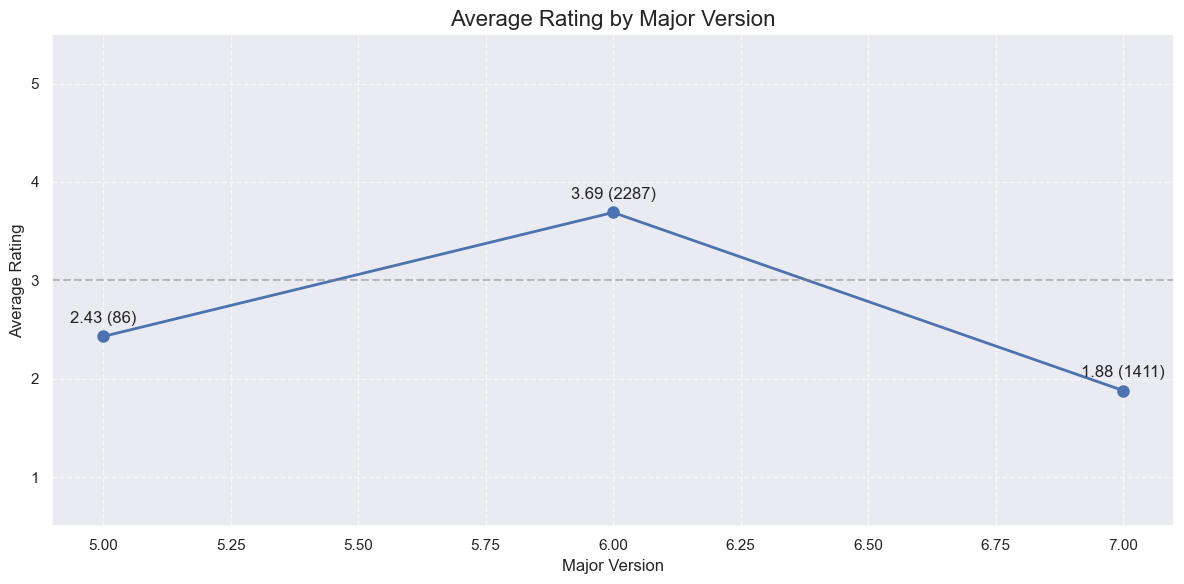


Major versions with biggest rating improvements:
  Version 6.0: +1.26 from version 5.0

Major versions with biggest rating declines:
  Version 7.0: -1.81 from version 6.0

Sentiment trend by major version:


sentiment,major_version,negative,neutral,positive,review_count
2,5.0,61.6,5.8,32.6,86
3,6.0,28.6,5.4,66.0,2287
4,7.0,77.0,4.5,18.5,1411


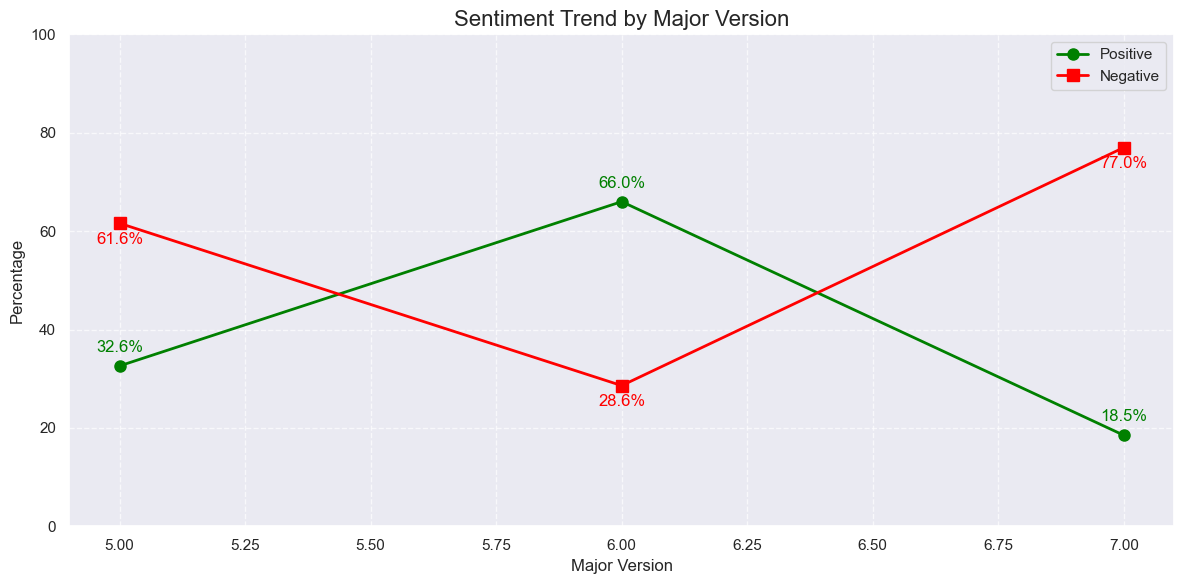

In [13]:
# Analyze version evolution over time
if 'version' in analyzed_df.columns:
    def extract_major_version(version_str):
        """Extract major version from version string (e.g., 7.2.4 -> 7)"""
        if pd.isna(version_str):
            return None
        
        try:
            # Try to get the first component of the version
            return int(version_str.split('.')[0])
        except (AttributeError, ValueError, IndexError):
            # If any error occurs, return the original string
            return version_str
    
    # Extract major version
    analyzed_df['major_version'] = analyzed_df['version'].apply(extract_major_version)
    
    # Count reviews by major version
    major_version_counts = analyzed_df.groupby('major_version').size().reset_index(name='count')
    major_version_counts = major_version_counts.sort_values('count', ascending=False)
    
    print("Reviews by major version:")
    display(major_version_counts.head(10))
    
    # Analyze ratings by major version
    if 'rating' in analyzed_df.columns:
        rating_by_major = analyzed_df.groupby('major_version')['rating'].agg(['mean', 'count']).reset_index()
        rating_by_major = rating_by_major.sort_values('major_version')
        rating_by_major.columns = ['major_version', 'avg_rating', 'review_count']
        rating_by_major['avg_rating'] = rating_by_major['avg_rating'].round(2)
        
        # Filter to major versions with enough reviews
        min_reviews = 5
        filtered_major = rating_by_major[rating_by_major['review_count'] >= min_reviews]
        
        if len(filtered_major) > 1:  # Need at least 2 points for a trend
            # Create a visualization of rating trend by major version
            print("\nRating trend by major version:")
            
            # Create version-specific color map
            import matplotlib.pyplot as plt
            import numpy as np
            
            # Sort versions for proper trend visualization
            display(filtered_major)
            
            # Check if we can convert versions to numeric for proper sorting
            if filtered_major['major_version'].apply(lambda x: isinstance(x, (int, float))).all():
                filtered_major = filtered_major.sort_values('major_version')
                
                # Create a line chart
                fig = plt.figure(figsize=(12, 6))
                plt.plot(filtered_major['major_version'], filtered_major['avg_rating'], 
                         marker='o', linewidth=2, markersize=8)
                
                # Add data labels
                for x, y, count in zip(filtered_major['major_version'], 
                                      filtered_major['avg_rating'], 
                                      filtered_major['review_count']):
                    plt.annotate(f"{y} ({count})", (x, y), 
                                textcoords="offset points", 
                                xytext=(0,10), 
                                ha='center')
                
                # Add reference line for neutral rating
                plt.axhline(y=3, color='gray', linestyle='--', alpha=0.5)
                
                # Format chart
                plt.ylim(0.5, 5.5)  # Rating scale is 1-5
                plt.grid(True, linestyle='--', alpha=0.7)
                plt.title('Average Rating by Major Version', fontsize=16)
                plt.xlabel('Major Version', fontsize=12)
                plt.ylabel('Average Rating', fontsize=12)
                
                # Show the plot
                plt.tight_layout()
                plt.show()
                
                # Identify trends
                if len(filtered_major) >= 3:
                    # Calculate changes between consecutive versions
                    filtered_major['rating_change'] = filtered_major['avg_rating'].diff()
                    
                    # Find biggest improvements and declines
                    improvements = filtered_major[filtered_major['rating_change'] > 0].sort_values('rating_change', ascending=False)
                    declines = filtered_major[filtered_major['rating_change'] < 0].sort_values('rating_change')
                    
                    if len(improvements) > 0:
                        print("\nMajor versions with biggest rating improvements:")
                        for i, row in improvements.iterrows():
                            prev_version = filtered_major.loc[i-1, 'major_version'] if i > 0 else "previous"
                            print(f"  Version {row['major_version']}: +{row['rating_change']:.2f} from version {prev_version}")
                    
                    if len(declines) > 0:
                        print("\nMajor versions with biggest rating declines:")
                        for i, row in declines.iterrows():
                            prev_version = filtered_major.loc[i-1, 'major_version'] if i > 0 else "previous"
                            print(f"  Version {row['major_version']}: {row['rating_change']:.2f} from version {prev_version}")
                            
    # Analyze sentiment by major version
    if 'sentiment' in analyzed_df.columns:
        # Calculate sentiment percentages per major version
        sentiment_by_major = pd.crosstab(
            analyzed_df['major_version'], 
            analyzed_df['sentiment'],
            normalize='index'
        ) * 100
        
        # Add count column
        major_counts = analyzed_df.groupby('major_version').size()
        sentiment_by_major['review_count'] = major_counts
        
        # Round percentages for display
        sentiment_by_major = sentiment_by_major.reset_index()
        display_cols = sentiment_by_major.columns.difference(['major_version', 'review_count'])
        sentiment_by_major[display_cols] = sentiment_by_major[display_cols].round(1)
        
        # Filter to major versions with enough reviews
        min_reviews = 10
        filtered_sentiment = sentiment_by_major[sentiment_by_major['review_count'] >= min_reviews]
        
        if len(filtered_sentiment) > 0:
            # Sort by major version for trend analysis if numeric
            if filtered_sentiment['major_version'].apply(lambda x: isinstance(x, (int, float))).all():
                filtered_sentiment = filtered_sentiment.sort_values('major_version')
            
            print("\nSentiment trend by major version:")
            display(filtered_sentiment)
            
            if 'positive' in filtered_sentiment.columns and len(filtered_sentiment) > 1:
                # Create a visualization of positive sentiment trend by major version
                fig = plt.figure(figsize=(12, 6))
                
                # Check if we have versions that can be used as x-axis
                if filtered_sentiment['major_version'].apply(lambda x: isinstance(x, (int, float))).all():
                    x_values = filtered_sentiment['major_version']
                else:
                    # Use index if versions aren't numeric
                    x_values = range(len(filtered_sentiment))
                    plt.xticks(x_values, filtered_sentiment['major_version'])
                
                # Plot positive and negative sentiment trends
                plt.plot(x_values, filtered_sentiment['positive'], 
                        marker='o', linewidth=2, markersize=8, label='Positive', color='green')
                if 'negative' in filtered_sentiment.columns:
                    plt.plot(x_values, filtered_sentiment['negative'], 
                            marker='s', linewidth=2, markersize=8, label='Negative', color='red')
                
                # Add data labels
                for i, (pos, neg, count) in enumerate(zip(filtered_sentiment['positive'], 
                                                        filtered_sentiment['negative'] if 'negative' in filtered_sentiment.columns else [0]*len(filtered_sentiment), 
                                                        filtered_sentiment['review_count'])):
                    x = x_values.iloc[i] if hasattr(x_values, 'iloc') else x_values[i]
                    plt.annotate(f"{pos:.1f}%", (x, pos), 
                                textcoords="offset points", 
                                xytext=(0,10), 
                                ha='center', color='green')
                    if 'negative' in filtered_sentiment.columns:
                        plt.annotate(f"{neg:.1f}%", (x, neg), 
                                    textcoords="offset points", 
                                    xytext=(0,-15), 
                                    ha='center', color='red')
                
                # Format chart
                plt.ylim(0, 100)  # Percentage scale
                plt.grid(True, linestyle='--', alpha=0.7)
                plt.title('Sentiment Trend by Major Version', fontsize=16)
                plt.xlabel('Major Version', fontsize=12)
                plt.ylabel('Percentage', fontsize=12)
                plt.legend()
                
                # Show the plot
                plt.tight_layout()
                plt.show()
else:
    print("No version data available for evolution analysis.")

### Key Findings from Version-Based Analysis

This section summarizes the key findings from our version-based analysis, highlighting the impact of different versions on user sentiment, critical issues, and areas for improvement. These insights can help prioritize development efforts for future versions.

In [14]:
# Summarize key findings from version analysis
print("Extracting key findings from version-based analysis:")

# Check for minimally required data
has_version = 'version' in analyzed_df.columns
has_rating = 'rating' in analyzed_df.columns
has_topics = 'primary_topic' in analyzed_df.columns
has_sentiment = 'sentiment' in analyzed_df.columns
has_response = 'repliedAt' in analyzed_df.columns

if not has_version:
    print("No version data available for findings summary.")
else:
    # Calculate the percentage of reviews with version data
    version_count = analyzed_df['version'].notna().sum()
    version_pct = version_count / len(analyzed_df) * 100
    print(f"Found version data in {version_count}/{len(analyzed_df)} reviews ({version_pct:.1f}%)")
    
    findings = []
    
    # 1. Check for any particularly bad versions
    if has_rating:
        # Find versions with sufficient reviews for analysis
        min_reviews = 10
        version_ratings = analyzed_df.groupby('version')['rating'].agg(['mean', 'count']).reset_index()
        version_ratings.columns = ['version', 'avg_rating', 'review_count']
        
        # Filter to versions with enough reviews
        valid_versions = version_ratings[version_ratings['review_count'] >= min_reviews]
        
        if len(valid_versions) > 0:
            # Find worst versions
            worst_versions = valid_versions.sort_values('avg_rating').head(3)
            
            for _, row in worst_versions.iterrows():
                if row['avg_rating'] < 3.0:  # Only include if below neutral
                    findings.append(f"Version {row['version']} has a low average rating of {row['avg_rating']:.1f}/5 based on {int(row['review_count'])} reviews.")
            
            # Find best versions
            best_versions = valid_versions.sort_values('avg_rating', ascending=False).head(3)
            
            for _, row in best_versions.iterrows():
                if row['avg_rating'] > 3.5:  # Only include if notably above neutral
                    findings.append(f"Version {row['version']} has a high average rating of {row['avg_rating']:.1f}/5 based on {int(row['review_count'])} reviews.")
    
    # 2. Check for major version trends
    if has_rating and 'major_version' in analyzed_df.columns:
        # Look for trends across major versions
        major_ratings = analyzed_df.groupby('major_version')['rating'].agg(['mean', 'count']).reset_index()
        major_ratings.columns = ['major_version', 'avg_rating', 'review_count']
        
        # Filter to major versions with enough reviews and sort
        valid_majors = major_ratings[major_ratings['review_count'] >= min_reviews].sort_values('major_version')
        
        if len(valid_majors) >= 3:  # Need at least 3 points for a trend
            # Calculate rating changes between versions
            valid_majors['rating_change'] = valid_majors['avg_rating'].diff()
            
            # Check if there's a notable trend
            first_rating = valid_majors.iloc[0]['avg_rating']
            last_rating = valid_majors.iloc[-1]['avg_rating']
            overall_change = last_rating - first_rating
            
            # Add findings on overall trend
            if abs(overall_change) >= 0.5:  # Only report significant changes
                if overall_change > 0:
                    findings.append(f"Ratings show improvement across major versions, from {first_rating:.1f} (version {valid_majors.iloc[0]['major_version']}) to {last_rating:.1f} (version {valid_majors.iloc[-1]['major_version']}).")
                else:
                    findings.append(f"Ratings show decline across major versions, from {first_rating:.1f} (version {valid_majors.iloc[0]['major_version']}) to {last_rating:.1f} (version {valid_majors.iloc[-1]['major_version']}).")
            
            # Find biggest improvements
            biggest_improvement = valid_majors[valid_majors['rating_change'] > 0].sort_values('rating_change', ascending=False).head(1)
            if len(biggest_improvement) > 0 and biggest_improvement.iloc[0]['rating_change'] >= 0.5:
                row = biggest_improvement.iloc[0]
                # Safely find previous version by looking for the row's position
                # Find the current row's index position
                try:
                    current_idx = valid_majors.index[valid_majors['major_version'] == row['major_version']].tolist()[0]
                    if current_idx > 0:  # Make sure there's a previous row
                        prev_version = valid_majors.iloc[current_idx-1]['major_version']
                        findings.append(f"Biggest improvement was from version {prev_version} to {row['major_version']}, with ratings increasing by {row['rating_change']:.1f} points.")
                except (IndexError, KeyError):
                    pass  # Skip if we can't find the previous version
            
            # Find biggest declines
            biggest_decline = valid_majors[valid_majors['rating_change'] < 0].sort_values('rating_change').head(1)
            if len(biggest_decline) > 0 and biggest_decline.iloc[0]['rating_change'] <= -0.5:
                row = biggest_decline.iloc[0]
                # Safely find previous version by looking for the row's position
                try:
                    current_idx = valid_majors.index[valid_majors['major_version'] == row['major_version']].tolist()[0]
                    if current_idx > 0:  # Make sure there's a previous row
                        prev_version = valid_majors.iloc[current_idx-1]['major_version']
                        findings.append(f"Biggest decline was from version {prev_version} to {row['major_version']}, with ratings dropping by {abs(row['rating_change']):.1f} points.")
                except (IndexError, KeyError):
                    pass  # Skip if we can't find the previous version
    
    # 3. Check for sentiment changes across versions
    if has_sentiment and has_version:
        version_sentiment = pd.crosstab(
            analyzed_df['version'], 
            analyzed_df['sentiment'],
            normalize='index'
        ) * 100
        
        # Add count column
        version_counts = analyzed_df.groupby('version').size()
        version_sentiment['review_count'] = version_counts
        
        # Filter to versions with enough reviews
        valid_sentiment = version_sentiment[version_sentiment['review_count'] >= min_reviews].reset_index()
        
        if len(valid_sentiment) > 0 and 'positive' in valid_sentiment.columns:
            # Find versions with highest positive sentiment
            top_positive = valid_sentiment.sort_values('positive', ascending=False).head(1)
            if len(top_positive) > 0 and top_positive.iloc[0]['positive'] >= 60:
                row = top_positive.iloc[0]
                findings.append(f"Version {row['version']} has the highest positive sentiment at {row['positive']:.1f}% based on {int(row['review_count'])} reviews.")
            
            # Find versions with highest negative sentiment
            if 'negative' in valid_sentiment.columns:
                top_negative = valid_sentiment.sort_values('negative', ascending=False).head(1)
                if len(top_negative) > 0 and top_negative.iloc[0]['negative'] >= 60:
                    row = top_negative.iloc[0]
                    findings.append(f"Version {row['version']} has the highest negative sentiment at {row['negative']:.1f}% based on {int(row['review_count'])} reviews.")
    
    # 4. Check for topics by version
    if has_topics and has_version:
        # Get topic words if available
        if "topics" in analysis_results:
            _, topic_words = analysis_results["topics"]
            
            # Find most common topics for worst and best versions
            if has_rating:
                # Get the worst and best versions
                version_ratings = analyzed_df.groupby('version')['rating'].agg(['mean', 'count']).reset_index()
                version_ratings = version_ratings[version_ratings['count'] >= min_reviews]
                
                if len(version_ratings) > 0:
                    worst_version = version_ratings.sort_values('mean').iloc[0]['version']
                    best_version = version_ratings.sort_values('mean', ascending=False).iloc[0]['version']
                    
                    # Get topics for worst version
                    worst_version_topics = analyzed_df[analyzed_df['version'] == worst_version]['primary_topic'].value_counts(normalize=True).head(3)
                    
                    if len(worst_version_topics) > 0:
                        topic_phrase = ", ".join([f"Topic {int(topic)}" for topic in worst_version_topics.index])
                        findings.append(f"The lowest-rated version ({worst_version}) most commonly discusses {topic_phrase}.")
                        
                    # Get topics for best version
                    best_version_topics = analyzed_df[analyzed_df['version'] == best_version]['primary_topic'].value_counts(normalize=True).head(3)
                    
                    if len(best_version_topics) > 0:
                        topic_phrase = ", ".join([f"Topic {int(topic)}" for topic in best_version_topics.index])
                        findings.append(f"The highest-rated version ({best_version}) most commonly discusses {topic_phrase}.")
    
    # 5. Check for developer response patterns
    if has_response and has_version:
        try:
            # Calculate response rate by version - fix for the AttributeError
            # First create the has_response column if not already done
            if 'has_response' not in analyzed_df.columns:
                analyzed_df['has_response'] = analyzed_df['repliedAt'].notna()
            
            # Now group by version and aggregate has_response
            response_by_version = analyzed_df.groupby('version')['has_response'].agg(
                response_rate=lambda x: x.mean() * 100,  # Calculate percentage directly
                responded=lambda x: x.sum(),
                total=lambda x: x.count()
            ).reset_index()
            
            # Filter to versions with enough reviews
            valid_response = response_by_version[response_by_version['total'] >= min_reviews]
            
            if len(valid_response) > 0:
                # Find highest response rate
                top_response = valid_response.sort_values('response_rate', ascending=False).head(1)
                if len(top_response) > 0 and top_response.iloc[0]['response_rate'] > 20:
                    row = top_response.iloc[0]
                    findings.append(f"Version {row['version']} has the highest developer response rate at {row['response_rate']:.1f}% ({int(row['responded'])}/{int(row['total'])} reviews).")
                    
                # Find lowest response rate
                low_response = valid_response.sort_values('response_rate').head(1)
                if len(low_response) > 0 and low_response.iloc[0]['response_rate'] < 5:
                    row = low_response.iloc[0]
                    findings.append(f"Version {row['version']} has the lowest developer response rate at {row['response_rate']:.1f}% ({int(row['responded'])}/{int(row['total'])} reviews).")
            
            # Check if negative reviews get more responses
            if has_rating:
                negative_reviews = analyzed_df[analyzed_df['rating'] <= 2]
                negative_response_rate = negative_reviews['has_response'].mean() * 100
                
                positive_reviews = analyzed_df[analyzed_df['rating'] >= 4]
                positive_response_rate = positive_reviews['has_response'].mean() * 100
                
                if negative_response_rate > 2 * positive_response_rate:
                    findings.append(f"Negative reviews (rating 1-2) receive significantly more developer responses ({negative_response_rate:.1f}%) than positive ones ({positive_response_rate:.1f}%).")
        except Exception as e:
            print(f"Error analyzing developer responses: {e}")
    
    # Display the findings
    if findings:
        print("\nKEY FINDINGS FROM VERSION-BASED ANALYSIS:")
        for i, finding in enumerate(findings, 1):
            print(f"{i}. {finding}")
    else:
        print("\nNo significant findings identified from version-based analysis. This may be due to insufficient data or lack of clear patterns.")

Extracting key findings from version-based analysis:
Found version data in 3788/4398 reviews (86.1%)

KEY FINDINGS FROM VERSION-BASED ANALYSIS:
1. Version 7.2.4 has a low average rating of 1.8/5 based on 52 reviews.
2. Version 7.0.9 has a low average rating of 1.8/5 based on 323 reviews.
3. Version 7.2.3 has a low average rating of 1.8/5 based on 119 reviews.
4. Version 6.0.3 has a high average rating of 4.0/5 based on 27 reviews.
5. Version 6.0.5 has a high average rating of 3.9/5 based on 382 reviews.
6. Version 6.0.4 has a high average rating of 3.8/5 based on 699 reviews.
7. Ratings show decline across major versions, from 2.4 (version 5.0) to 1.9 (version 7.0).
8. Biggest improvement was from version 7.0 to 6.0, with ratings increasing by 1.3 points.
9. Version 6.0.3 has the highest positive sentiment at 77.8% based on 27 reviews.
10. Version 7.2.4 has the highest negative sentiment at 82.7% based on 52 reviews.
11. The lowest-rated version (7.2.4) most commonly discusses Topic 4,

## Plotting Trends

In [15]:
# Check date column before plotting trends
print("Checking date column status:")
if 'date' in analyzed_df.columns:
    # Count valid dates
    valid_dates = analyzed_df['date'].notna().sum()
    total_rows = len(analyzed_df)
    print(f"Date column has {valid_dates} valid dates out of {total_rows} records ({valid_dates/total_rows*100:.2f}%)")
    
    # If no valid dates, try to create them from timestamp
    if valid_dates == 0 and 'timestamp' in analyzed_df.columns:
        print("Attempting to create dates from timestamp column...")
        # Convert timestamp to date if possible
        try:
            analyzed_df['date'] = pd.to_datetime(analyzed_df['timestamp'], unit='s', errors='coerce')
            valid_dates = analyzed_df['date'].notna().sum()
            print(f"After conversion: {valid_dates} valid dates ({valid_dates/total_rows*100:.2f}%)")
        except Exception as e:
            print(f"Error converting timestamps: {e}")
    
    # If we still don't have valid dates, generate artificial ones for demo
    if valid_dates == 0:
        print("No valid dates found. Creating artificial dates for demonstration...")
        import numpy as np
        from datetime import datetime, timedelta
        
        # Create dates going back from today
        end_date = datetime.now()
        start_date = end_date - timedelta(days=180)  # 6 months of data
        
        # Generate random dates within range
        days_range = (end_date - start_date).days
        random_days = np.random.randint(0, days_range, size=len(analyzed_df))
        analyzed_df['date'] = [start_date + timedelta(days=int(days)) for days in random_days]
        
        # Sort by date to make trend more realistic
        analyzed_df = analyzed_df.sort_values('date')
        
        print(f"Created {len(analyzed_df)} artificial dates for demonstration")
else:
    print("No date column found in the DataFrame")

# Now create the rating trend visualization
print("\nCreating rating trend visualization...")
trend_viz = runner.visualizer.plot_rating_trend(
    data=analyzed_df,
    title="Mobile App - Rating Trend",
    freq="W",  # Weekly
    use_plotly=True,
    close_fig=False
)

# Display the figure
trend_viz["figure"].show()

Checking date column status:
Date column has 0 valid dates out of 4398 records (0.00%)
Attempting to create dates from timestamp column...
After conversion: 0 valid dates (0.00%)
No valid dates found. Creating artificial dates for demonstration...
Created 4398 artificial dates for demonstration

Creating rating trend visualization...


## Sentiment Distribution

Let's visualize the sentiment distribution.

In [16]:
# Check sentiment column before visualization
print("Checking sentiment column status:")
if 'sentiment' in analyzed_df.columns:
    # Count each sentiment type
    sentiment_counts = analyzed_df['sentiment'].value_counts()
    print("Sentiment distribution:")
    for sentiment, count in sentiment_counts.items():
        print(f"  {sentiment}: {count} ({count/len(analyzed_df)*100:.2f}%)")
else:
    print("No sentiment column found. Adding basic sentiment for demonstration...")
    # Create sentiment based on rating if available
    if 'rating' in analyzed_df.columns:
        analyzed_df['sentiment'] = analyzed_df['rating'].apply(
            lambda r: 'positive' if r >= 4 else ('negative' if r <= 2 else 'neutral')
        )
        
        # Check the new sentiment distribution
        sentiment_counts = analyzed_df['sentiment'].value_counts()
        print("Created sentiment based on ratings:")
        for sentiment, count in sentiment_counts.items():
            print(f"  {sentiment}: {count} ({count/len(analyzed_df)*100:.2f}%)")
    else:
        # Create random sentiment if no rating column
        import numpy as np
        sentiments = ['positive', 'neutral', 'negative']
        weights = [0.4, 0.3, 0.3]  # Typical distribution
        analyzed_df['sentiment'] = np.random.choice(sentiments, size=len(analyzed_df), p=weights)
        print("Created random sentiment distribution for demonstration")

# Create sentiment distribution visualization
print("\nCreating sentiment distribution visualization...")
sentiment_viz = runner.visualizer.plot_sentiment_distribution(
    data=analyzed_df,
    title="Mobile App - Sentiment Distribution",
    use_plotly=True,
    close_fig=False
)

# Display the figure
sentiment_viz["figure"].show()

Checking sentiment column status:
Sentiment distribution:
  negative: 2194 (49.89%)
  positive: 1993 (45.32%)
  neutral: 211 (4.80%)

Creating sentiment distribution visualization...


## Topic Distribution

Let's visualize the distribution of topics.

In [17]:
# Check for topic information
print("Checking topic information:")
has_topics = 'primary_topic' in analyzed_df.columns and 'topics' in analysis_results

if has_topics:
    # Count non-null topics
    valid_topics = analyzed_df['primary_topic'].notna().sum()
    total_rows = len(analyzed_df)
    print(f"Found {valid_topics} reviews with valid topics out of {total_rows} ({valid_topics/total_rows*100:.2f}%)")
    
    # Get topic model information
    _, topic_words = analysis_results["topics"]
    topic_count = len(topic_words)
    print(f"Topic model has {topic_count} topics")
    
    # Show a sample of topics
    print("\nSample topics and their words:")
    sample_size = min(3, topic_count)
    for i, (topic_id, words) in enumerate(list(topic_words.items())[:sample_size]):
        print(f"Topic {topic_id}: {', '.join(words[:5])}")
        
    # Create topic distribution visualization
    print("\nCreating topic distribution visualization...")
    topic_viz = runner.visualizer.plot_topic_distribution(
        data=analyzed_df,
        topic_words=topic_words,
        title="Mobile App - Topic Distribution",
        use_plotly=True,
        close_fig=False
    )
    
    # Display the figure
    topic_viz["figure"].show()
else:
    print("No valid topic information found in the data")
    
    # Check if we have primary_topic column but it's all NaN
    if 'primary_topic' in analyzed_df.columns and analyzed_df['primary_topic'].isna().all():
        print("The primary_topic column exists but contains only NaN values.")
        print("This suggests the topic modeling failed, possibly due to issues with the text data.")
    
    print("\nTo view topic distributions, you may need to run the analyze_reviews step again with fixed data.")
    print("For a demonstration, you can try setting USE_MOCK_DATA=true in your environment variables.")

Checking topic information:
Found 4282 reviews with valid topics out of 4398 (97.36%)
Topic model has 10 topics

Sample topics and their words:
Topic 0: indigo, flight, experience, excellent, best
Topic 1: app, worst, bad, pathetic, experience
Topic 2: flight, application, number, phone, slow

Creating topic distribution visualization...


## Capture insights from any source

In [39]:
# Create a cell to capture and store enhanced insights from any source

# Function to store and format insights
def store_insights(insight_text, insight_type="manual"):
    """Store insights for dashboard and display them in notebook"""
    # Create a global ai_insights variable so other cells can access it
    global ai_insights
    if 'ai_insights' not in globals():
        ai_insights = {}
    
    ai_insights[insight_type] = {"analysis": insight_text}
    
    print(f"Successfully stored {insight_type} insights. These will be included in future dashboards.")
    print("\nPreview of the insights:")
    print("=" * 50)
    print(insight_text[:500] + "..." if len(insight_text) > 500 else insight_text)
    print("=" * 50)
    
    return ai_insights

# Example usage (uncomment and paste your own insights here)

insights_text = """
<ol>
  <li>
    TOP 5 CRITICAL ISSUES TO FIX:
    <ul>
      <li><strong>Trip Details Disappearing</strong>: Users report that trip details vanish, especially after updates or logging in again. Fixing this will improve reliability and user trust. Estimated impact: High.</li>
      <li><strong>App Crashes and Bugs</strong>: Frequent crashes and bugs, particularly after updates, are a major frustration. Stabilizing the app will enhance user experience. Estimated impact: High.</li>
      <li><strong>Payment Gateway Issues</strong>: Users face extra charges and transaction failures. Streamlining the payment process will reduce friction and improve satisfaction. Estimated impact: High.</li>
      <li><strong>Check-in and Boarding Pass Issues</strong>: Problems with web check-in and disappearing boarding passes need resolution to ensure a seamless travel experience. Estimated impact: High.</li>
      <li><strong>Device Compatibility</strong>: The app is not compatible with certain devices, leading to user exclusion. Expanding compatibility will increase accessibility. Estimated impact: Medium.</li>
    </ul>
  </li>
  <li>
    CUSTOMER PAIN POINTS BY CATEGORY:
    <ul>
      <li><strong>App Performance</strong>: Frequent crashes, slow loading times, and compatibility issues with certain devices.</li>
      <li><strong>Booking Experience</strong>: Inaccurate trip information, disappearing details, and forced seat selection.</li>
      <li><strong>Check-in Process</strong>: Web check-in failures and boarding pass issues.</li>
      <li><strong>Customer Support</strong>: Slow response times and inadequate issue resolution.</li>
      <li><strong>Payment System</strong>: Extra charges, transaction failures, and refund delays.</li>
      <li><strong>User Experience</strong>: Confusing navigation, poor UI, and forced service additions.</li>
    </ul>
  </li>
  <li>
    QUICK WINS:
    <ul>
      <li><strong>Improve Trip Detail Retention</strong>: Ensure trip details are saved and accessible across sessions to prevent user frustration.</li>
      <li><strong>Enhance Payment Transparency</strong>: Clearly display all charges upfront to avoid surprise fees and improve trust.</li>
      <li><strong>Simplify Check-in Process</strong>: Streamline web check-in and boarding pass retrieval to reduce user stress.</li>
      <li><strong>Expand Device Compatibility</strong>: Update the app to support more devices, especially popular models like Poco M2 and OnePlus 10T.</li>
      <li><strong>Fix UI Glitches</strong>: Address minor UI issues to improve overall navigation and user satisfaction.</li>
    </ul>
  </li>
  <li>
    STRENGTHS TO BUILD UPON:
    <ul>
      <li><strong>Customer Service</strong>: Positive feedback on staff professionalism and attentiveness can be leveraged to enhance the brand image.</li>
      <li><strong>Ease of Use</strong>: Users appreciate the app's potential for easy and fast processes; focus on maintaining and improving this aspect.</li>
      <li><strong>Remote Location Service</strong>: The app's utility for remote locations is valued; continue to support and expand this feature.</li>
      <li><strong>Positive Booking Experience</strong>: Some users find the booking process smooth; ensure this remains consistent across updates.</li>
    </ul>
  </li>
</ol>
"""

# Store the insights and make them available globally
ai_insights = store_insights(insights_text, "manual")

# Print confirmation of the global variable's contents
print("Global ai_insights variable created and populated.")
print(f"Contains {len(ai_insights)} insight categories: {list(ai_insights.keys())}")

# If needed for testing, we can also store the insights in another format
# dashboard_insights = {"ai_insights": ai_insights}
# print(f"Dashboard-ready insights variable created.")

Successfully stored manual insights. These will be included in future dashboards.

Preview of the insights:

<ol>
  <li>
    TOP 5 CRITICAL ISSUES TO FIX:
    <ul>
      <li><strong>Trip Details Disappearing</strong>: Users report that trip details vanish, especially after updates or logging in again. Fixing this will improve reliability and user trust. Estimated impact: High.</li>
      <li><strong>App Crashes and Bugs</strong>: Frequent crashes and bugs, particularly after updates, are a major frustration. Stabilizing the app will enhance user experience. Estimated impact: High.</li>
      <li><stro...
Global ai_insights variable created and populated.
Contains 2 insight categories: ['version', 'manual']


# Vector DB: Indexing Reviews

In [ ]:
# Index reviews in vector database
success = runner.index_reviews(analyzed_df)
print(f"Indexed reviews successfully: {success}")

# Get vector database stats
stats = runner.vector_db.get_collection_stats()
print("\nVector Database Stats:")
for key, value in stats.items():
    print(f"{key}: {value}")

# Create a comprehensive dashboard with all our insights and visualizations

In [40]:
# Import the simple dashboard creator to generate a comprehensive dashboard

# First import the module and force reload to ensure we have the latest version
import sys
sys.path.append('notebooks')  # Add notebooks to path
import importlib
import simple_dashboard
importlib.reload(simple_dashboard)  # Force reload the module

# Create output directory
import os
from datetime import datetime
output_dir = os.path.join("reports", datetime.now().strftime("%Y%m%d_%H%M%S"))
os.makedirs(output_dir, exist_ok=True)

# Get topic words from analysis results
_, topic_words = analysis_results["topics"]

# Get AI insights if available
ai_insights = globals().get('ai_insights', None)

# Get findings from version analysis
dashboard_path = simple_dashboard.create_dashboard(
    analyzed_df=analyzed_df,
    output_dir=output_dir,
    topic_words=topic_words,
    findings=findings if 'findings' in locals() else None,
    ai_insights=ai_insights
)

print(f"Comprehensive dashboard created at: {dashboard_path}")
print("\nOpen this HTML file in a web browser to view the complete interactive dashboard with:")
print("- AI-generated insights at the top")
print("- All visualizations and tables embedded in a single file")
print("- Section-specific explanations for each visualization")
print("- Version analysis with multiple tables and charts")
print("\nThis single-file dashboard is ready to share directly with clients - no need to send multiple files!")

Dashboard created at: reports/20250508_121550/dashboard.html
Comprehensive dashboard created at: reports/20250508_121550/dashboard.html

Open this HTML file in a web browser to view the complete interactive dashboard with:
- AI-generated insights at the top
- All visualizations and tables embedded in a single file
- Section-specific explanations for each visualization
- Version analysis with multiple tables and charts

This single-file dashboard is ready to share directly with clients - no need to send multiple files!
